# **Multivariate Weather Data Clustering using New CNN Model**

# **1. CNN Model Definition:**
Here I have created a new CNN model to process our daily data as an image of sze 41x41x7. The model takes 41x41x7 numpy array as input and applies 8 convolution layers, 3 max polling layers, and 2 dense layers with dimension [2048, 512]. The output of this model is 512 features for each day's data. 

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
#from keras.preprocessing.image import ImageDataGenerator.  tanh. relu
import numpy as np

def myCNNModel(input_dims):
  '''
  The value of the parameter input_dims is the size of the input image/data we want to train on, for our data it is (41, 41, 7)
  '''
  model = Sequential()
  model.add(Conv2D(input_shape=input_dims,filters=64,kernel_size=(3,3),padding="same", activation="tanh"))
  #model.add(keras.layers.BatchNormalization())
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="tanh"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.1))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="tanh"))
  #model.add(keras.layers.BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="tanh"))
  #model.add(keras.layers.BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="tanh"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.1))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="tanh"))
  #model.add(keras.layers.BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="tanh"))
  #model.add(keras.layers.BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="tanh"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Flatten(name='flatten'))
  model.add(Dense(2048, activation='relu', name='fc1'))
  model.add(Dense(512, activation='relu', name='fc2'))
  return model


# **2. Model Creation:**
The clustering layer for this model is crerated by using k-means clustering. Then the final model is created by adding this clustering layer at the end of the CNNModel. The trained model is stored in the drive for future use. 

In [2]:

from time import time
import numpy as np
import keras.backend as K
#from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
#import metrics


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it. 
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class CNNModel(object):
    def __init__(self,
                 dims,
                 n_clusters=10, 
                 alpha=1.0,
                 init='glorot_uniform'):

        super(CNNModel, self).__init__()

        self.dims = dims
        #self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.model_cnn = myCNNModel(self.dims);
        print("====Model created=====")

        # prepare the CNN model with cnn_layers+clustering _layer
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.model_cnn.output)
        print("====== clustering layer created ========")
        self.model = Model(inputs=self.model_cnn.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.model_cnn.compile(optimizer=optimizer, loss='mse')
        print("=======Model pretraining started====")

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if int(epochs/10) != 0 and epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    #print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|' % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.model_cnn.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print("========the model fit is executed======")
        print('Pretraining time: %ds' % round(time() - t0))
        self.model_cnn.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.model_cnn.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        #save_interval = int(x.shape[0] / batch_size) * 5  # 5 epochs
        save_interval = 500
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.model_cnn.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/cnn_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                print("#### inside iteration ### ", ite)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                print("##### Prediction in side the iter and the delta_label is ", delta_label)
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            print("#### the loss is ", loss)
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/CNN_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/CNN_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/CNN_model_final.h5')
        self.model.save_weights(save_dir + '/CNN_model_final.h5')

        return y_pred

In [3]:
import netCDF4
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import datetime as dt
from netCDF4 import date2num,num2date
from math import sqrt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
rdata_daily = xr.open_dataset('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc') #.rename({'latitude':'lat','longitude':'lon'})
#rdata_daily = rioxarray.open_rasterio('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc').rename({'y':'lon','x':'lat'})
rdata_daily

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

# **3. Data preparation:**
Our daily data have some NaN values in the SST variable. To replace these NaN values I have used the mean value of that longitude and latitue of that day. If take mean from all the day it will misrepresent that data point. The function returns 2 numpy arrays one with size (365, 11767) and another with size (365, 41, 41, 7).

In [6]:
## This function will will pre-process our daily data for DEC model as numpy array
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def data_preprocessing(data_path):
  rdata_daily = xr.open_dataset(data_path)    # data_path = '/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc'
  rdata_daily_np_array = np.array(rdata_daily.to_array())   # the shape of the dailt data is (7, 365, 41, 41)
  rdata_daily_np_array_T = rdata_daily_np_array.transpose(1,0,2,3)   # transform the dailt data from (7, 365, 41, 41) to (365, 7, 41, 41)
  for i in range(rdata_daily_np_array_T.shape[0]):
    for j in range(rdata_daily_np_array_T.shape[1]):
      for k in range(rdata_daily_np_array_T.shape[2]):
        for l in range(rdata_daily_np_array_T.shape[3]):
          if np.isnan(rdata_daily_np_array_T[i, j, k, l]):
            #print("NAN data in ", i, j, k, l)
            rdata_daily_np_array_T[i, j, k, l]=np.nanmean(rdata_daily_np_array_T[i, j, k, :])
  rdata_daily_np_array_T = rdata_daily_np_array_T.transpose(0,2,3,1)
  rdata_daily_np_array_T_R = rdata_daily_np_array_T.reshape((rdata_daily_np_array_T.shape[0], -1))  # transform the dailt data from (365, 7, 41, 41) to (365, 11767)
  min_max_scaler = preprocessing.MinMaxScaler() # calling the function
  rdata_daily_np_array_T_R_nor = min_max_scaler.fit_transform(rdata_daily_np_array_T_R)   # now normalize the data, otherwise the loss will be very big 
  #rdata_daily_np_array_T_R_nor = np.float32(rdata_daily_np_array_T_R_nor)    # convert the data type to float32, otherwise the loass will be out-of-limit 
  rdata_daily_np_array_T_R_nor_R = rdata_daily_np_array_T_R_nor.reshape((rdata_daily_np_array_T_R_nor.shape[0], 41,41,7))
  return rdata_daily_np_array_T_R_nor, rdata_daily_np_array_T_R_nor_R


This function calculates the silhoutte score of the formed clusters.

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette_score(X, labels, *, metric="cosine", sample_size=None, random_state=None, **kwds):  
 return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))

In [9]:
data_nor_eval, data_clustering = data_preprocessing('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc')

In [ ]:
data_nor_eval.shape, data_clustering.shape

((365, 11767), (365, 41, 41, 7))

## **4. Model Training:**
This function defines related parameters to train the model. Then creates the model trains on the pre-processed data and the model tries to optimize the clustering loss. After training the model returns the cluster results. 

In [10]:
def main():
    # setting the hyper parameters

    #parser.add_argument('--batch_size', default=256, type=int)
    batch_size = 256
    #parser.add_argument('--maxiter', default=2e4, type=int)
    maxiter = 2e4
    #parser.add_argument('--pretrain_epochs', default=None, type=int)
    pretrain_epochs = 3
    #parser.add_argument('--update_interval', default=None, type=int)
    update_interval = 50
    #parser.add_argument('--tol', default=0.001, type=float)
    tol = 0.0000001
    #parser.add_argument('--ae_weights', default=None)
    ae_weights = None
    #parser.add_argument('--save_dir', default='results')
    save_dir = '/content/drive/MyDrive/My_CNN_result_2'
    #args = parser.parse_args()
    #print(args)

    # load dataset
    #from datasets import load_data
    #x, y = load_data(args.dataset)
    #n_clusters = len(np.unique(y))       rdata_daily_np_array_T_R_nor_R
    x = data_clustering
    y = None
    n_clusters = 7

    #init = 'glorot_uniform'
    init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
    #pretrain_optimizer = 'adam'
    pretrain_optimizer = SGD(learning_rate=0.1, momentum=0.9)
    # setting parameters

    # prepare the DEC model
    cnnmodel = CNNModel(dims=(41,41,7), n_clusters=n_clusters, init=init)

    #if ae_weights is None:
    #    dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
    #                 epochs=pretrain_epochs, batch_size=batch_size,
    #                 save_dir=save_dir)
    #else:
    #    dec.autoencoder.load_weights(ae_weights)

    cnnmodel.model.summary()
    t0 = time()
    cnnmodel.compile(optimizer=SGD(0.0000001, 0.9), loss='kld')#mse    kld
    y_pred = cnnmodel.fit(x, y=y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                     update_interval=update_interval, save_dir=save_dir)
    #print('acc:', metrics.acc(y, y_pred))
    print('clustering time: ', (time() - t0))
    return y_pred

In [78]:
res = main()
res

====Model created=====
====== clustering layer created ========
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_216_input (InputLaye  [(None, 41, 41, 7)]      0         
 r)                                                              
                                                                 
 conv2d_216 (Conv2D)         (None, 41, 41, 64)        4096      
                                                                 
 conv2d_217 (Conv2D)         (None, 41, 41, 64)        36928     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 dropout_54 (Dropout)        (None, 20, 20, 64)        0         
                                                            

array([3, 3, 3, 3, 3, 2, 2, 5, 3, 5, 3, 3, 5, 3, 3, 5, 3, 0, 0, 0, 5, 5,
       5, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 5, 5, 5, 5, 0, 0, 0, 0, 0,
       0, 2, 5, 5, 0, 2, 2, 0, 0, 2, 5, 3, 5, 3, 3, 5, 0, 0, 5, 5, 5, 5,
       5, 5, 5, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 0,
       2, 5, 3, 3, 3, 3, 3, 3, 5, 5, 5, 3, 3, 0, 5, 5, 5, 3, 5, 5, 5, 5,
       0, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 6, 6, 4, 6, 6, 6, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1,
       1, 1, 1, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 1,
       1, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 1, 4, 4,

fully connected layers: 2048, 512. tol = 0.0000001 update=50

In [79]:
silhouette_avg_rdata_daily = silhouette_score(data_nor_eval, res)  
print("The average silhouette_score is :", silhouette_avg_rdata_daily)

The average silhouette_score is : 0.2910500973868909


In [80]:
res_l = res

In [81]:
u,indices = np.unique(res,return_counts = True)
u,indices 

(array([0, 1, 2, 3, 4, 5, 6]), array([ 34,  45,  20,  34, 115,  66,  51]))

(array([0, 1, 2, 3, 4, 5, 6]), array([ 34,  45,  20,  34, 115,  66,  51]))

64, 64, max, drop 0.1, 128, 128, 128,max, drop 0.1, 256, 256, 256, max, flat, 2048, 512
tol=lr=0.0000001, update=50

The average silhouette_score is : 0.2910500973868909

array([3, 3, 3, 3, 3, 2, 2, 5, 3, 5, 3, 3, 5, 3, 3, 5, 3, 0, 0, 0, 5, 5,
       5, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 5, 5, 5, 5, 0, 0, 0, 0, 0,
       0, 2, 5, 5, 0, 2, 2, 0, 0, 2, 5, 3, 5, 3, 3, 5, 0, 0, 5, 5, 5, 5,
       5, 5, 5, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 0,
       2, 5, 3, 3, 3, 3, 3, 3, 5, 5, 5, 3, 3, 0, 5, 5, 5, 3, 5, 5, 5, 5,
       0, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 6, 6, 4, 6, 6, 6, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1,
       1, 1, 1, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 1,
       1, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 3, 2, 2,
       2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2])

## **5. Visualization:**
To visualize clustering results I have downloaded the python file from GitHub and loaded in the current runtime using file operation. As our current GitHub repository is private, so we can't import this directly from the GitHub. 

In [82]:

import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
path = '/content/drive/MyDrive/visualization.py'
path_1 = '/content/drive/MyDrive/coast.txt'
#r = requests.get(url)

# make sure your filename is the same as how you want to import 
#with open('visualization.py', 'w') as f:
#    f.write(r.text)

with open(path, "r") as file1:
    FileContent = file1.read()
    with open('visualization.py', 'w') as f:
      f.write(FileContent)
    #print(FileContent)

with open(path_1, "r") as file1:
    FileContent = file1.read()
    with open('coast.txt', 'w') as f:
      f.write(FileContent)
# now we can import
#import visualization as vis

In [83]:
import visualization as vis

In [85]:
df=pd.DataFrame()
df1=pd.DataFrame()
df['time_step'] = np.arange(len(res))
df['clusterid'] = pd.DataFrame(res)
df.to_csv('/content/drive/MyDrive/my-cnn-result_0.29.csv',index=True)

total clusters:  7
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/content/visualization.py:128: RuntimeWarning: Mean of empty slice
  var_mean_icluster = np.nanmean(var_icluster,axis=0)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/content/visualization.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.subplot(panel)
/content/visualization.py:71: UserWarning: The following kwargs were not used by contour: 'linewidth'
  p1=ax.contour(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/11),extend = 'both',linewidth=0.6)


varid: t2m
var_range: [-0.08280723076385484, -0.07839707801928061]
varid: u10
var_range: [-15.129702662479593, 16.82725476413482]
varid: v10
var_range: [-14.294945017569995, 14.039669939743764]
varid: sshf
var_range: [-43.41541985801895, 175.22246693947238]
varid: sp
var_range: [985.3787786916515, 1035.1150602330122]


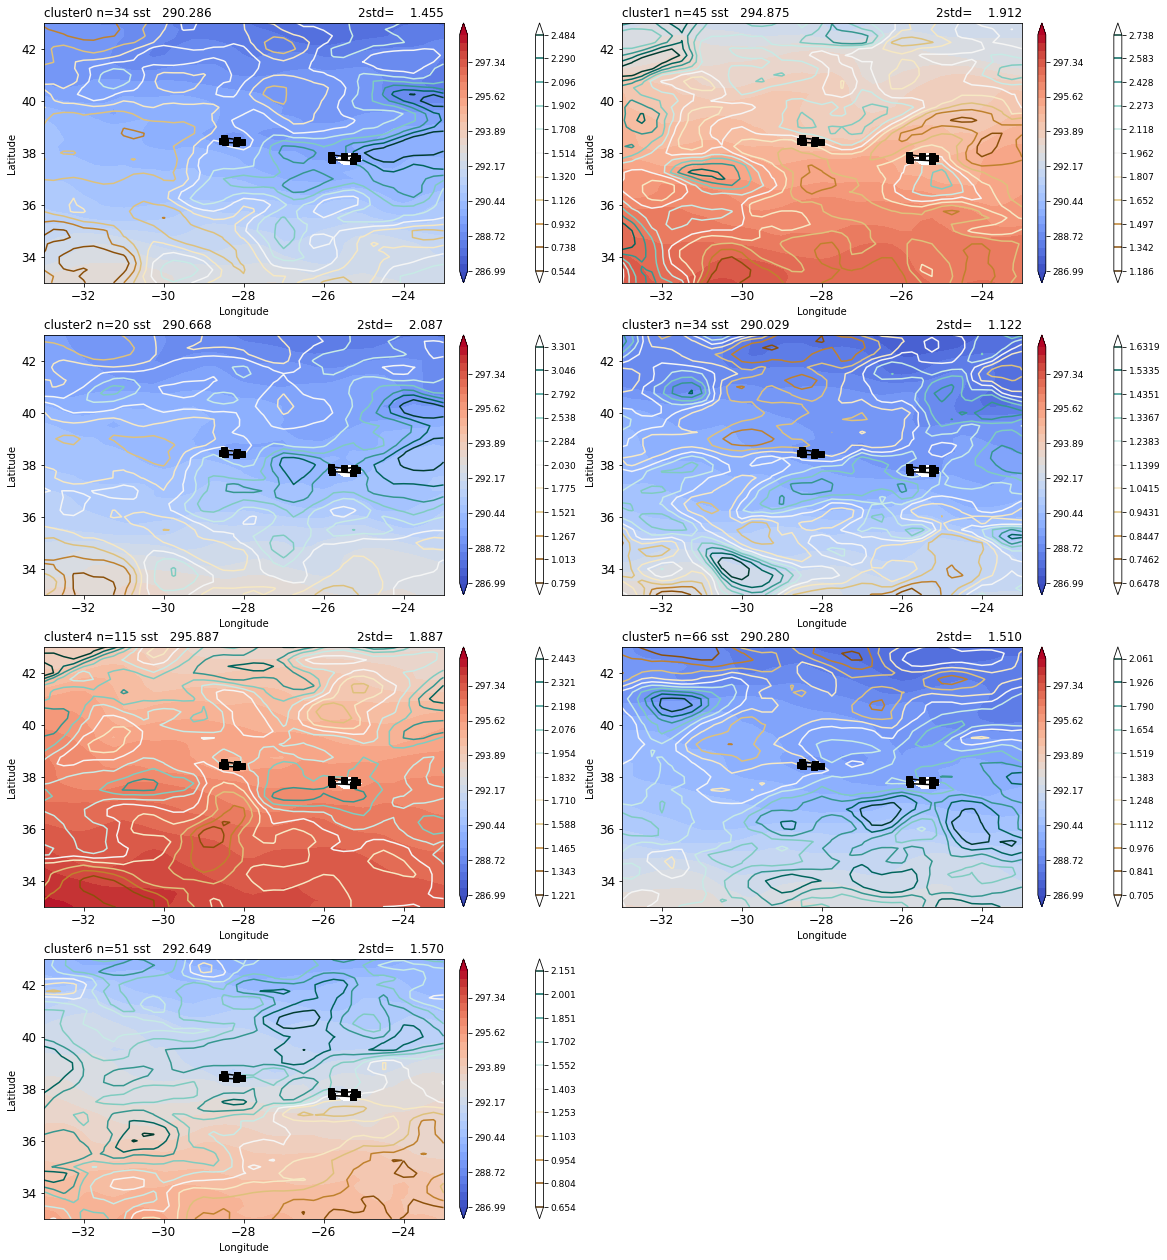

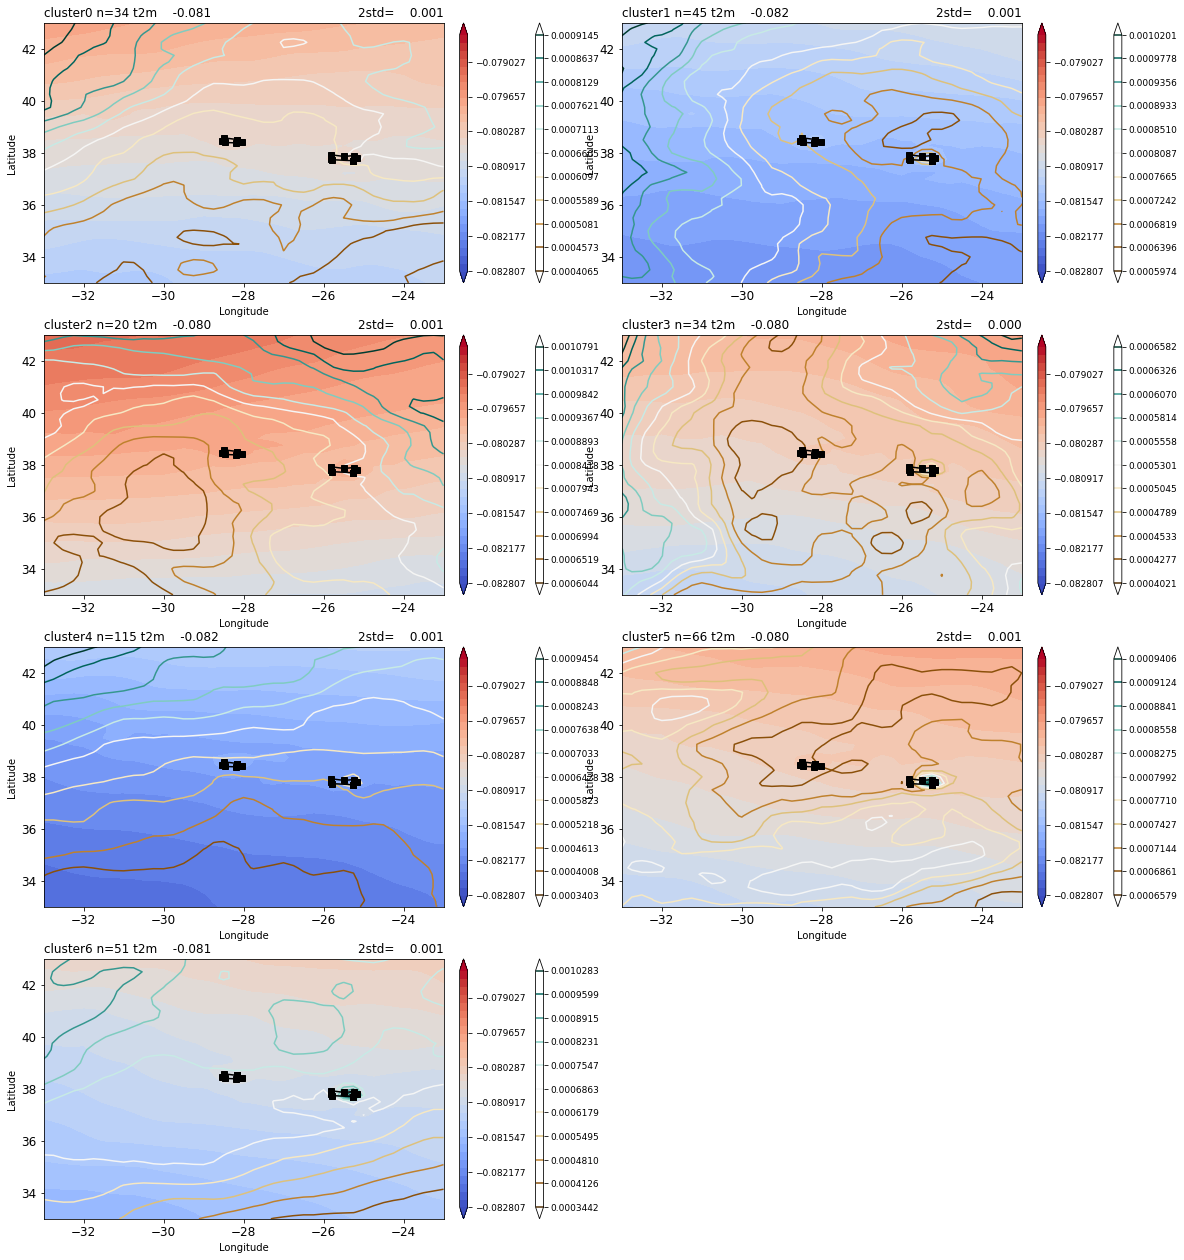

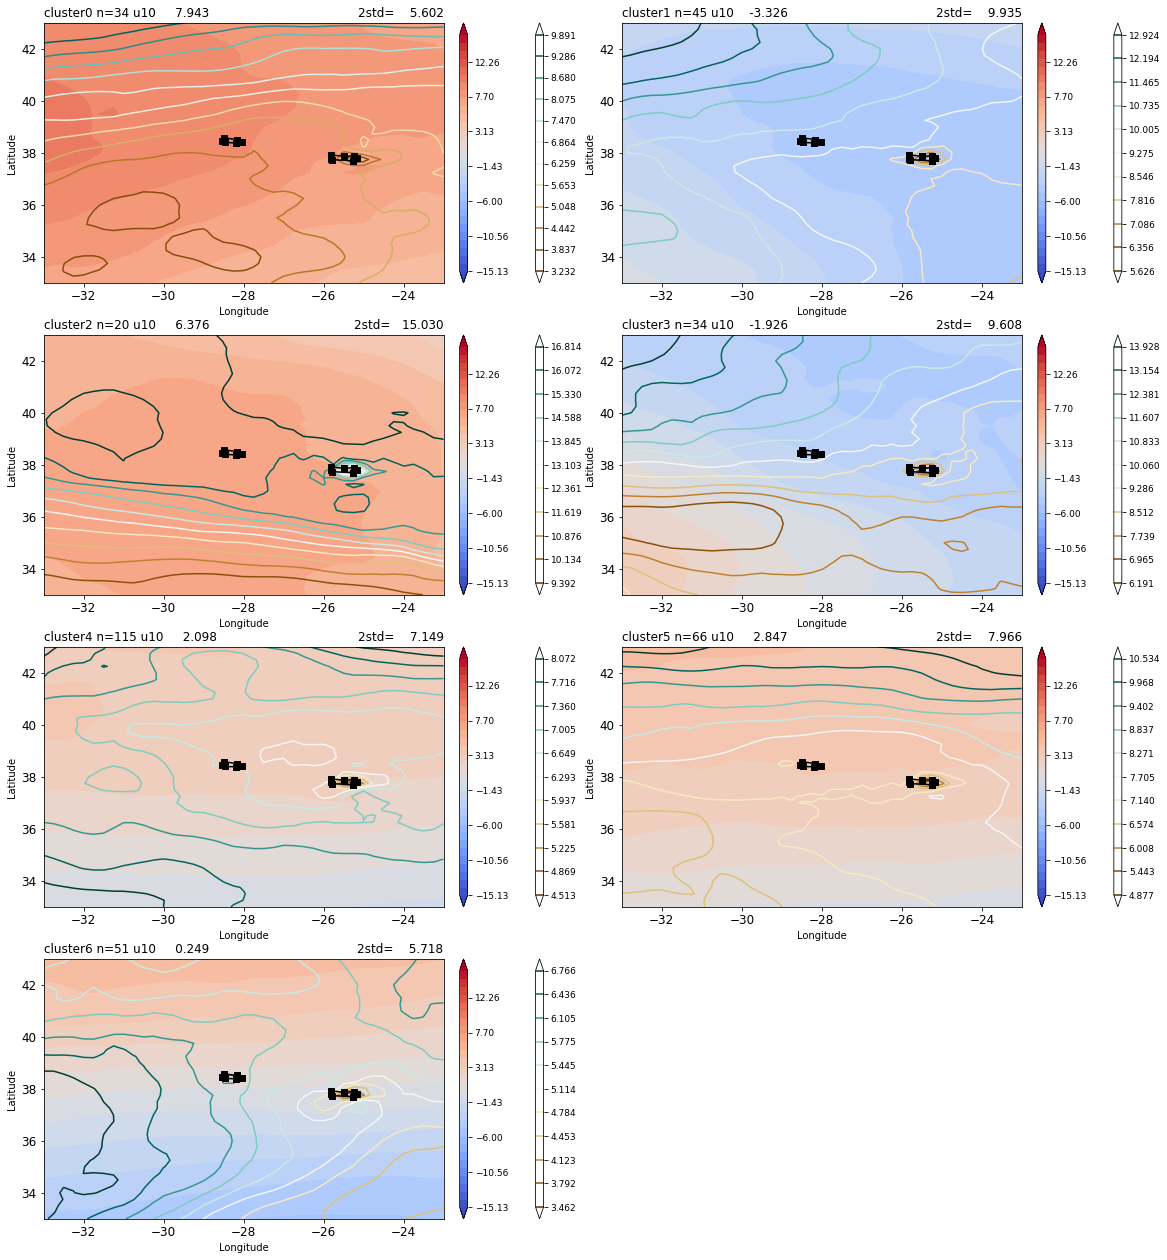

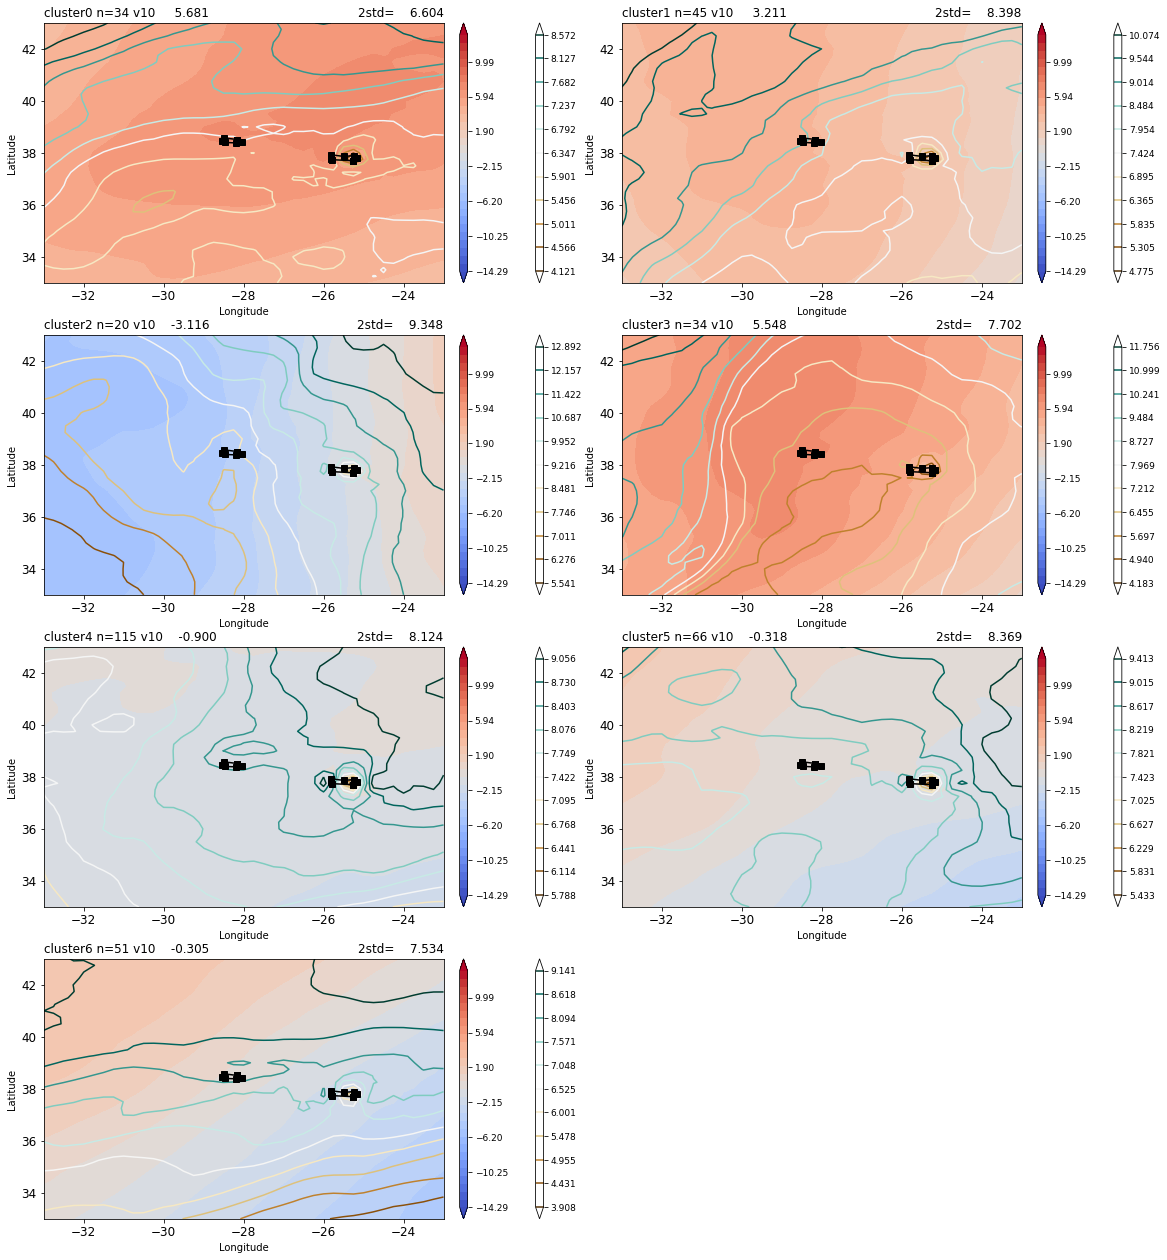

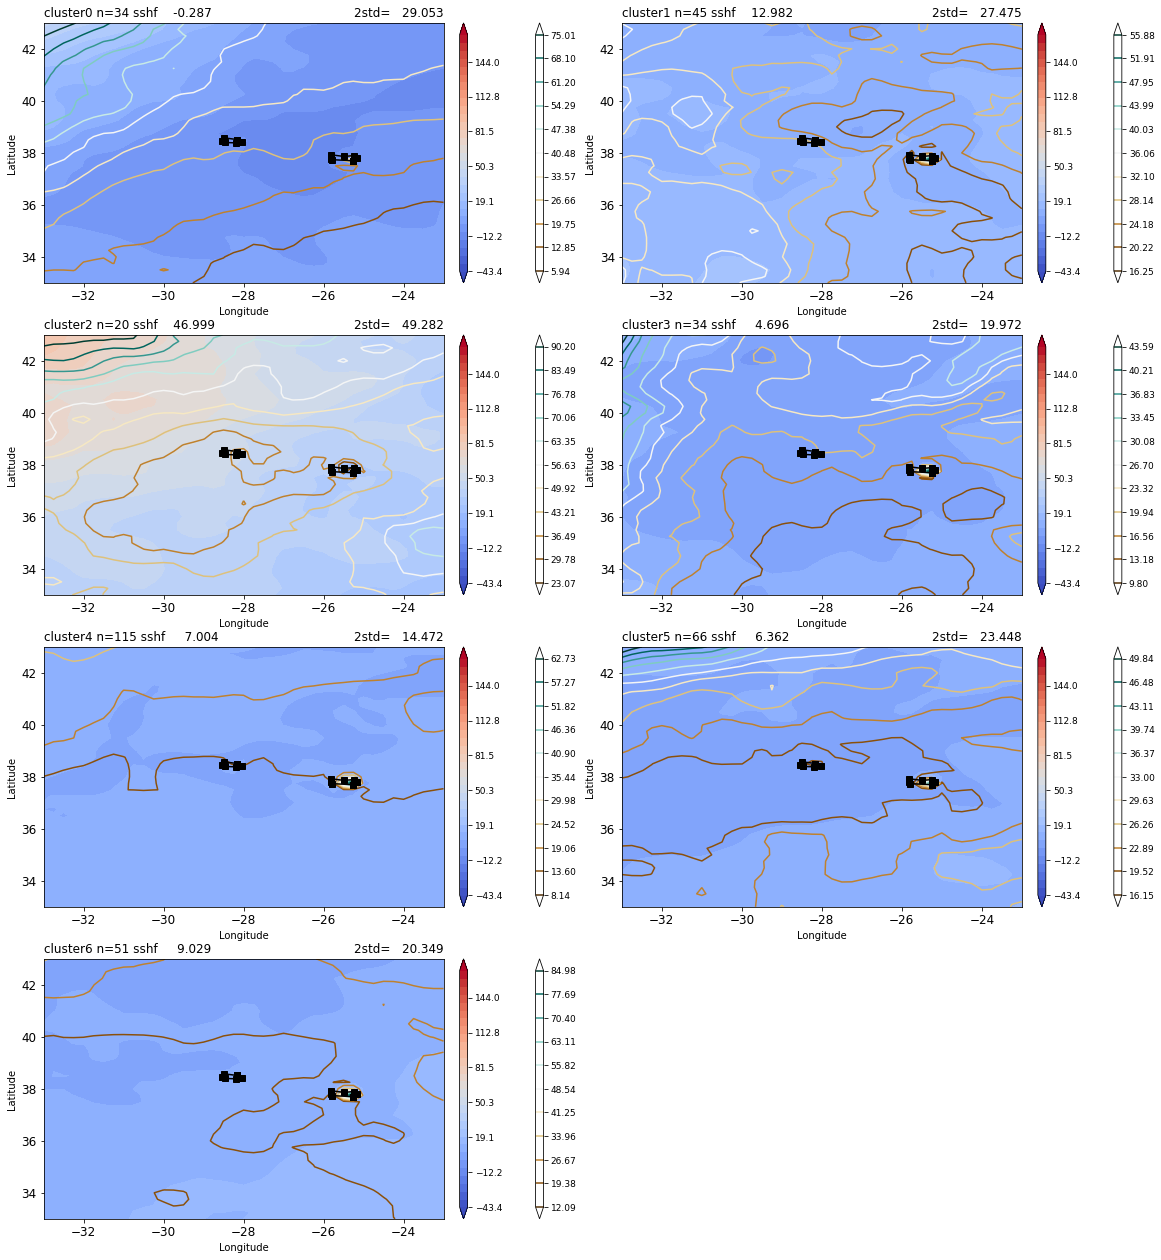

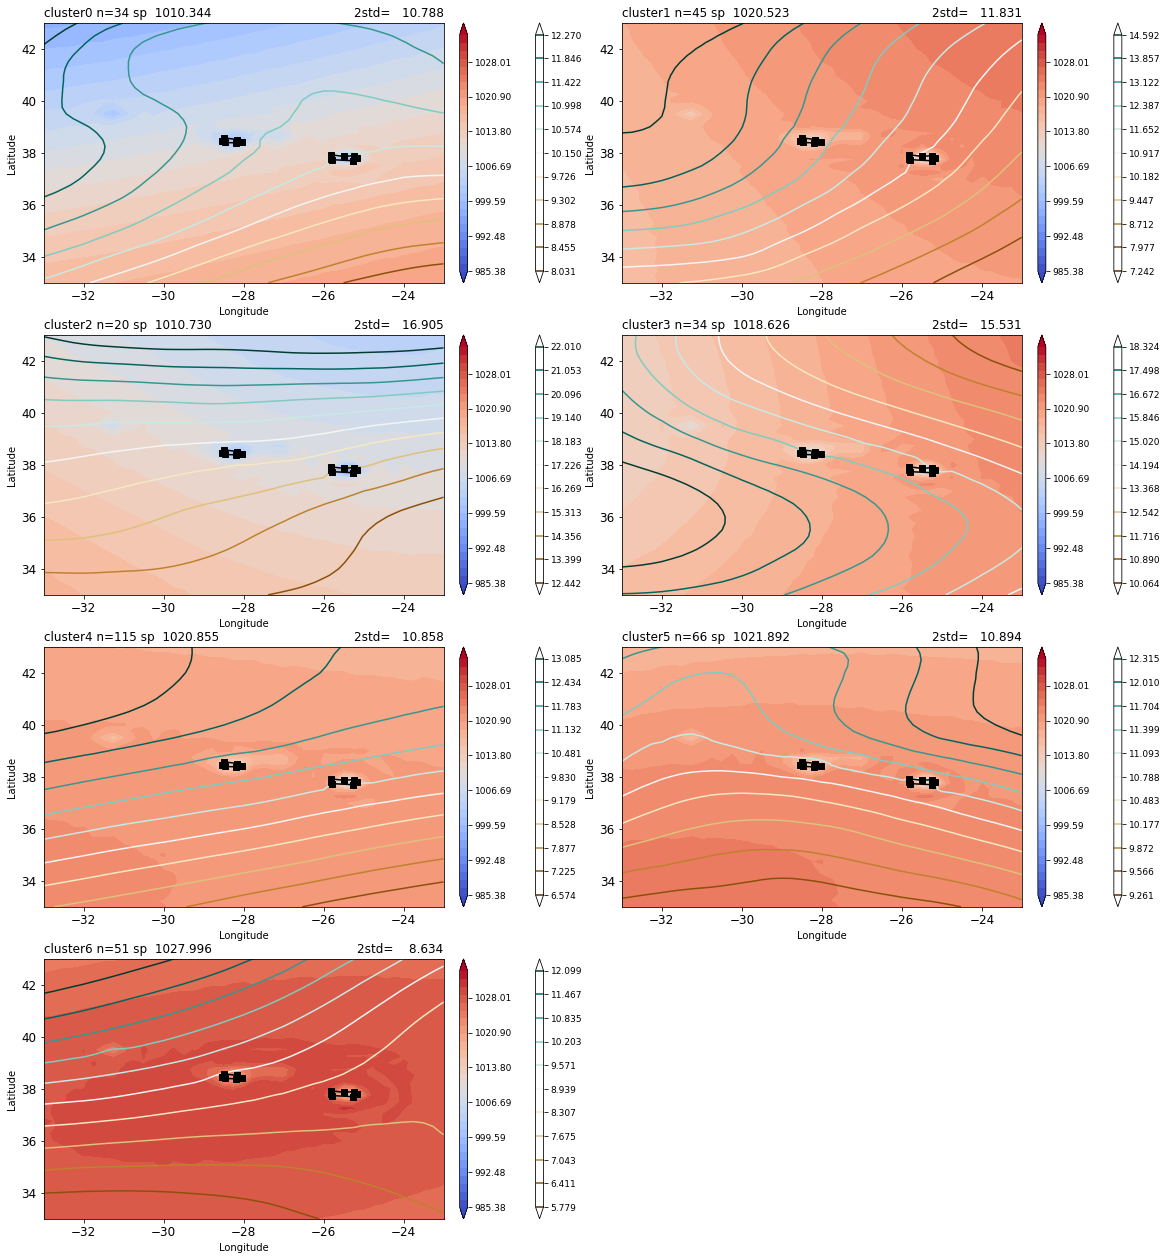

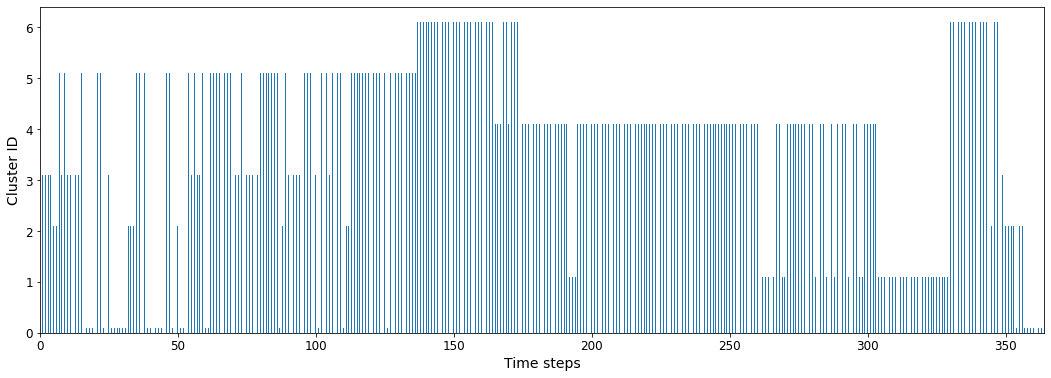

In [86]:
vis.visualization('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc' ,'/content/drive/MyDrive/my-cnn-result_0.29.csv', './coast.txt')

##**Evaluation metrics:**

In [87]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
from sklearn.preprocessing import StandardScaler
import dask.dataframe

### Transforming Data & Standardizing features by removing the mean and scaling to unit variance. ###

#### Transformation function for Daily Data.

def transformddaily(x):
  import dask.dataframe
# Transforming Data
  dask_df = x.to_dask_dataframe(dim_order=None, set_index=False)
  dd = dask_df.compute()
  sst_data_trans = pd.DataFrame()
  t2m_data_trans = pd.DataFrame()
  v10_data_trans = pd.DataFrame()
  u10_data_trans = pd.DataFrame()
  sp_data_trans = pd.DataFrame()
  sshf_data_trans = pd.DataFrame()
  slhf_data_trans = pd.DataFrame()

  for i in range(0,dd.shape[0]):
    b=('sst'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    c=('t2m'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    d=('v10'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    e=('u10'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    f=('sp'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    g=('sshf'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    h=('slhf'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')

    sst_data_trans.loc[dd.time[i], b] = dd.sst[i]
    t2m_data_trans.loc[dd.time[i], c] = dd.t2m[i]
    v10_data_trans.loc[dd.time[i], d] = dd.v10[i]
    u10_data_trans.loc[dd.time[i], e] = dd.u10[i]
    sp_data_trans.loc[dd.time[i], f] = dd.sp[i]
    sshf_data_trans.loc[dd.time[i], g] = dd.sshf[i]
    slhf_data_trans.loc[dd.time[i], h] = dd.slhf[i]
#Removing Null Values
  sst_data_trans1 = sst_data_trans.values.astype(float)
  sst_data_trans1=sst_data_trans.fillna(9999)

  t2m_data_trans1 = t2m_data_trans.values.astype(float)
  t2m_data_trans1= t2m_data_trans.fillna(9999)
  
  v10_data_trans1 = v10_data_trans.values.astype(float)
  v10_data_trans1=v10_data_trans.fillna(9999)
  
  u10_data_trans1 = u10_data_trans.values.astype(float)
  u10_data_trans1=u10_data_trans.fillna(9999)

  sp_data_trans = sp_data_trans.values.astype(float)
  sp_data_trans1= sp_data_trans.fillna(9999)

  sshf_data_trans1 = sshf_data_trans.values.astype(float)
  sshf_data_trans1= sshf_data_trans.fillna(9999)

  slhf_data_trans1 = slhf_data_trans.values.astype(float)
  slhf_data_trans1= slhf_data_trans.fillna(9999)

  trans_concat = pd.concat([sst_data_trans1, t2m_data_trans1, v10_data_trans1, u10_data_trans1, sp_data_trans1, sshf_data_trans1, slhf_data_trans1 ], axis=1)
  scaler = StandardScaler()
  trans_concat_scaled = scaler.fit_transform(trans_concat)
  return trans_concat_scaled


#### Transformation function for Daily Data ONLY SST.
def ssttransform(x):
  import dask.dataframe
# Transforming Data
  dask_df = x.to_dask_dataframe(dim_order=None, set_index=False)
  dd = dask_df.compute()
  sst_data_trans = pd.DataFrame()

  for i in range(0,dd.shape[0]):
    b=('sst'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    sst_data_trans.loc[dd.time[i], b] = dd.sst[i]
#Removing Null Values
  sst_data_trans1 = sst_data_trans.values.astype(float)
  sst_data_trans1=sst_data_trans.fillna(9999) 
  trans_concat = pd.concat([sst_data_trans1 ], axis=1)
  scaler = StandardScaler()
  trans_concat_scaled = scaler.fit_transform(trans_concat)
  return trans_concat_scaled


#### Transformation function for Mock Data.

def transformdmock(x):
  import dask.dataframe
# Transforming Data
  dask_df = x.to_dask_dataframe(dim_order=None, set_index=False)
  dd = dask_df.compute()
  sst_data_trans = pd.DataFrame()
  t2m_data_trans = pd.DataFrame()

  for i in range(0,dd.shape[0]):
    b=('sst'+'('+str(dd.lat[i])+','+str(dd.lon[i])+')')
    c=('t2m'+'('+str(dd.lat[i])+','+str(dd.lon[i])+')')

    sst_data_trans.loc[dd.time[i], b] = dd.sst[i]
    t2m_data_trans.loc[dd.time[i], c] = dd.t2m[i]

#Concating the variables 
  trans_concat = pd.concat([sst_data_trans, t2m_data_trans], axis=1)
  scaler = StandardScaler()
  trans_concat_scaled = scaler.fit_transform(trans_concat)
  return trans_concat_scaled


def datatransformation(input):
    
    '''This function is used to transform the xarray dataset into a pandas dataframe where the dimension "time" would become the index of the DataFrame and,
      pairs of both dimensions "latitude" and "longitude" will become the columns for each variable'''
    
    # If the given input is a string, the below block will be executed
    if isinstance(input, str) == True:
        data1 = data[input]

        # The below line will convert the xarray into a dask dataframe
        dask_df = data1.to_dask_dataframe(dim_order=None, set_index=False)
        # The below line will convert the dask dataframe into a pandas dataframe
        pd_df = dask_df.compute()

        # The below loop will handle missing values in each and every column of the dataframe by substituting mean of individual columns in the place of the missing values
        for i in pd_df.columns:
          if pd_df[i].isna().sum() > 0:
            pd_df[i].fillna(value=pd_df[i].mean(), inplace=True)
        
        # Since the pandas dataframe (p_df) will also have the dimensions of the xarray as columns, we'll have to remove them. Below code handles that part.
        col = 'time','latitude','longitude'
        fin_df = pd_df.loc[:, ~pd_df.columns.isin(col)]

        # trans_data will be the final dataframe that the function will return.
        trans_data = pd.DataFrame()
        for j in fin_df.columns:
          for i in range(0,pd_df.shape[0]):
              c=(j + '(' + str(pd_df.latitude[i])+','+str(pd_df.longitude[i]) + ')') # Every variable followed by the pairs of latitude and longitude will become the columns
              trans_data.loc[pd_df.time[i], c] = pd_df[j][i] # Based on the column name (var+ (lat,lon)), the correct value of each variable will sit in the right place.

        return trans_data

    # If the input is any thing other than a string, the below code will be executed.
    else:
        # The below line will convert the xarray into a dask dataframe
        dask_df = input.to_dask_dataframe(dim_order=None, set_index=False)
        # The below line will convert the dask dataframe into a pandas dataframe
        pd_df = dask_df.compute()

        # The below loop will handle missing values in each and every column of the dataframe by substituting mean of individual columns in the place of the missing values
        for i in pd_df.columns:
          if pd_df[i].isna().sum() > 0:
            pd_df[i].fillna(value=pd_df[i].mean(), inplace=True)
        
        # Since the pandas dataframe (p_df) will also have the dimensions of the xarray as columns, we'll have to remove them. Below code handles that part.
        col = 'time','latitude','longitude'
        fin_df = pd_df.loc[:, ~pd_df.columns.isin(col)]

        # trans_data will be the final dataframe that the function will return.
        trans_data = pd.DataFrame()
        for j in fin_df.columns:
          for i in range(0,pd_df.shape[0]):
              c=(j + '(' + str(pd_df.latitude[i])+','+str(pd_df.longitude[i]) + ')') # Every variable followed by the pairs of latitude and longitude will become the columns
              trans_data.loc[pd_df.time[i], c] = pd_df[j][i] # Based on the column name (var+ (lat,lon)), the correct value of each variable will sit in the right place.

        return trans_data



######################## physics based #######################

#Function to input NaN values across variables

def null_fill(input):

  dask_df = input.to_dask_dataframe(dim_order=None, set_index=False)
  pd_df = dask_df.compute()
  pd_df1 = pd_df.iloc[:, 3:]
  df2 = pd_df1[pd_df1.isnull().any(axis=1)]
  lst = list(df2.index.values)
  df2.loc[:] = np.nan
  dt = pd.concat([pd_df1, df2], axis=0)
  dt3 = dt[~dt.index.duplicated(keep='last')]
  dt4 = dt3[['sst', 'sp', 'u10', 'v10', 'sshf', 'slhf', 't2m']]
  pd_df4 = pd_df.iloc[:, 0:5]
  dff = pd_df4[['time', 'longitude', 'latitude', 'sst']]
  df = pd.merge(dff, dt4, left_index=True, right_index=True).drop('sst_y', axis=1)
  df.rename(columns={'sst_x':'sst'}, inplace=True)
  df_rows = pd.DataFrame(df).set_index(["time", "longitude", "latitude"])
  data = xr.Dataset.from_dataframe(df_rows)
  df_rows = pd.DataFrame(df).set_index(["time", "longitude", "latitude"])
  data = xr.Dataset.from_dataframe(df_rows)

  return data

  ################## end of physics based ##################

  #################### Data Normilization #################
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def datanormalization(input):
    ''' This function is used to normalize the data that is passed to it. Input in this case will be the transformed pandas dataframe. '''
    x = input.values # returns a numpy array
    min_max_scaler = MinMaxScaler() # calling the function
    x_scaled = min_max_scaler.fit_transform(x) # x_scaled will hold the values of the normalized data
    
    # trans_data will hold the same columns and index of the dataframe that is passed to it. And the values will be the ones saved in x_scaled
    trans_data = pd.DataFrame(x_scaled, columns=input.columns, index=input.index)
        
    return trans_data

################ end of data normalization ################

######## PCA #########

from sklearn.decomposition import PCA

def pca1(data,n): # data is data to be input , n is the number of components 
  pca = PCA(n_components=n) 
  pca.fit(data)

  # Get pca scores
  pca_scores = pca.transform(data)

  # Convert pca_scores to a dataframe
  scores_df = pd.DataFrame(pca_scores)

  # Round to two decimals
  scores_df = scores_df.round(2)

  # Return scores
  return scores_df

######## End of PCA #########

######## PCAcomponents function ##########
def pcacomponents(data):
  import matplotlib.pyplot as plt
  pca = PCA().fit(data)
  plt.rcParams["figure.figsize"] = (12,6)
  fig, ax = plt.subplots()
  xi = np.arange(1, 20, step=1)
  y = np.cumsum(pca.explained_variance_ratio_)

  plt.ylim(0.0,1.1)
  plt.xlim(0.0,14)
  plt.plot( y, marker='o', linestyle='--', color='b')

  plt.xlabel('Number of Components')
  plt.xticks(np.arange(0, 20, step=1)) #change from 0-based array index to 1-based human-readable label
  plt.ylabel('Cumulative variance (%)')
  plt.title('The number of components needed to explain variance')

  plt.axhline(y=0.95, color='r', linestyle='-')
  plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

  ax.grid(axis='x')
  return plt.show()

  ######## End of PCAcomponents function #########

In [94]:
def spatial_evaluation(input, formed_clusters):


  '''
  input: 
        datatype: 4-D spatio-temporal xarray
        formed_clusters: 1-D array of cluster labels classifying each data point along the time dimension
                         to a cluster label
  Output:
         
        An N X M matrix whose diagonal is a measure of intra-spatial correlation between data points in a cluster
        while the rest of the values represent the inter-spatial correlation between data points in different clusters.
     
  '''


  if null_fill == "yes":

    data = null_fill(input)

    #calling function that transforms our data
    trans_data = datatransformation(data)

    #Normalize data
    trans_data = datanormalization(trans_data)

    trans_data['Cluster'] = formed_clusters

  else:
    #calling function that transforms our data
    trans_data = datatransformation(input)

    #Normalize data
    norm_data = datanormalization(trans_data)

    trans_data['Cluster'] = formed_clusters
  
  # Function to get center of dataset (compute the mean value of all centroids)

  # Non-normalized
  # Function that creates a dictionary that holds all the cluster centers
  def data_centroid(input,formed_clusters): #classification
    Cluster_Centers = {}
    centers = []
    Center = []
    Clusters = n_nor_get_clusters(input,formed_clusters)
    for i in set(formed_clusters):
      Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
      centers.append(Cluster_Centers['Cluster_Center' + str(i)])

    centers_sum = sum(centers)
    centers = []
    n = len(Cluster_Centers['Cluster_Center' + str(i)])
    Centers_sum = np.sum(sum(sum(centers_sum/n)))
    Center.append(Centers_sum)

    return Center

  # Function that creates a dictionary that holds the values of dates in each cluster
  def get_datewise_clusters(formed_clusters): # classification
    Dates_Cluster = {}
    for i in set(formed_clusters): # classification
      Dates_Cluster['Dates_Cluster'+str(i)] = trans_data.index[trans_data.Cluster == i].to_list()
    return Dates_Cluster


  # Function that creats a dictionary that holds all the clusters
  def n_nor_get_clusters(input,formed_clusters): # classification
    com_arr = []
    Clusters = {}
    Dates_Cluster = get_datewise_clusters(formed_clusters)
    for i in set(formed_clusters):
      for j in Dates_Cluster['Dates_Cluster'+str(i)]:
        arr = np.array(input.isel(time=j).to_array()) # input is data
        com_arr.append(arr)
      Clusters['Cluster' + str(i)] = np.array(com_arr)
      com_arr = []
    return Clusters

  # Function that creates a dictionary that holds all the cluster centers
  def n_nor_get_cluster_centers(input,formed_clusters): #classification
    Cluster_Centers = {}
    Clusters = n_nor_get_clusters(input,formed_clusters)
    for i in set(formed_clusters):
      Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    return Cluster_Centers


  #Intra RMSE Calculation Function
  def n_nor_intra_rmse(input,formed_clusters):
    sq_diff = []
    intra_rmse = []
    Clusters = n_nor_get_clusters(input,formed_clusters)
    Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)

    for i in range(len(Clusters)):
      for j in range(len(Clusters['Cluster' + str(i)])):
        diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
        Sq_diff = (diff**2)
        sq_diff.append(Sq_diff)
      Sq_diff_sum = sum(sq_diff)
      sq_diff = []
      n = len(Clusters['Cluster' + str(i)])
      Sqrt_diff_sum = np.sqrt(sum(sum(sum(Sq_diff_sum/n))))
      intra_rmse.append(Sqrt_diff_sum)
    return intra_rmse


  # Normalized
  # Function that creates two dictionaries that hold all the clusters and cluster centers
  def nor_get_clusters_and_centers(input,formed_clusters):
    Clusters = {}
    Cluster_Centers = {}
    for i in set(formed_clusters):
      Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
      Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    return Clusters,Cluster_Centers


  def nor_intra_rmse(input,formed_clusters):
    intra_rmse = []
    sq_diff = []
    Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
    for i in range(len(Clusters)):
      for j in range(len(Clusters['Cluster' + str(i)])):
        diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
        Sq_diff = (diff**2)
        sq_diff.append(Sq_diff)
      Sq_diff_sum = sum(sum(sq_diff))
      sq_diff = []
      n = len(Clusters['Cluster' + str(i)])
      Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
      intra_rmse.append(Sqrt_diff_sum)
    return intra_rmse


########################################       #######################################


  # RMSE Calculation
  def RMSE(input,formed_clusters,normalize=False):
    inter_rmse = []
    avg_cluster = {}

    if normalize == False:
      #input = handle_missing_values(input)
      Clusters = n_nor_get_clusters(input,formed_clusters)
      trans_data['Cluster'] = formed_clusters
      mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
      for i in range(len(Clusters)):
        avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
      for i in range(len(Clusters)):
        for j in range(len(Clusters)):
          if i == j:
            a = n_nor_intra_rmse(input,formed_clusters)
            mat[i].iloc[j] = round(a[i],2)
          else:
            diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
            Sq_diff = (diff**2)
            #Sq_diff_sum = sum(Sq_diff)
            Sq_diff_sum = sum(sum(sum(Sq_diff)))
            #inter_rmse.append(np.sqrt(Sq_diff_sum))
            n = len(avg_cluster['avg_cluster'+str(i)][0])
            Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
            mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:')
          

    else:
      # trans_data = datatransformation(input)

      # # Data Normalization
      # trans_data = datanormalization(trans_data)

      # # Adding class centers and cluster numbers as columns to the dataframe
      # trans_data['Cluster'] = formed_clusters

      # # Rearranging the columns in the dataframe
      # trans_data = trans_data[['Cluster'] + [c for c in trans_data if c not in ['Cluster']]]
    
      Clusters, Cluster_Centers = nor_get_clusters_and_centers(trans_data,formed_clusters)

      # Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
      #trans_data = trans_data.reset_index()

    
      mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
      for i in range(len(Clusters)):
        avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
      for i in range(len(Clusters)):
        for j in range(len(Clusters)):
          if i == j:
            a = nor_intra_rmse(trans_data,formed_clusters)
            mat[i].iloc[j] = round(a[i],2)
          else:
            diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
            Sq_diff = (diff**2)
            #Sq_diff_sum = sum(Sq_diff)
            Sq_diff_sum = sum(Sq_diff)
            #inter_rmse.append(np.sqrt(Sq_diff_sum))
            Sqrt_diff_sum = np.sqrt(Sq_diff_sum)
            mat[i].iloc[j] = round(Sqrt_diff_sum,2)
            #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())

    return mat




  def pearson_PM(x, y):

    #convert format from netcdf to np array
    #x_form = x.to_numpy()
    #y_form = y.to_numpy()

    #Flatten/transform from 2d to 1d
    X_flat = x.flatten()
    Y_flat = y.flatten()

    #Compute correlation matrix
    corr_mat = np.corrcoef(X_flat, Y_flat)

    #Return entry [0,1]
    return corr_mat[0,1]


  #Intra-spatial correlation coefficient Calculation Function
  import functools 

  def n_nor_intra_sp_corr(input,formed_clusters):
    mylist = []
    intra_sp_corr = []
    Clusters = n_nor_get_clusters(input,formed_clusters)
    Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)
    
    for i in range(len(Clusters)):
      mylist = []
      for j in range(len(Clusters['Cluster' + str(i)])):
        corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][j], Cluster_Centers['Cluster_Center' + str(i)])
        #print('i: {}, j: {}, corr_coeff:{}'.format(i, j, corr_coeff))
        mylist.append(corr_coeff)
        average_corr_coeff = sum(mylist) / len(mylist)
      intra_sp_corr.append(average_corr_coeff)
    return intra_sp_corr

  

    #Intra-spatial correlation coefficient Calculation Function
  import functools 

  def sp_corr(input,formed_clusters):
    avg_cluster = {}
    Clusters = n_nor_get_clusters(input,formed_clusters)
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = n_nor_intra_sp_corr(input,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          corr_coeff = pearson_PM(avg_cluster['avg_cluster' + str(i)], avg_cluster['avg_cluster' + str(j)])
          mat[i].iloc[j] = corr_coeff
            #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
      return mat



  #Normalized - Intra-spatial correlation coefficient Calculation Function
  def nor_intra_sp_corr(input,formed_clusters):
    mylist = []
    intra_sp_corr = []
    Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
    
    for i in range(len(Clusters)):
      mylist = []
      for j in range(len(Clusters['Cluster' + str(i)])):
        corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][j], Cluster_Centers['Cluster_Center' + str(i)])
        #print('i: {}, j: {}, corr_coeff:{}'.format(i, j, corr_coeff))
        mylist.append(corr_coeff)
        average_corr_coeff = sum(mylist) / len(mylist)
      intra_sp_corr.append(average_corr_coeff)
    return intra_sp_corr



      # Non-normalized Spatial Correlation Calculation
  def sp_corr(input,formed_clusters,normalize=False):
    inter_sp_corr = []
    avg_cluster = {}

    if normalize == False:
      #input = handle_missing_values(input)
      Clusters = n_nor_get_clusters(input,formed_clusters)
      trans_data['Cluster'] = formed_clusters
      mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
      for i in range(len(Clusters)):
        avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
      for i in range(len(Clusters)):
        for j in range(len(Clusters)):
          if i == j:
            a = n_nor_intra_sp_corr(input,formed_clusters)
            mat[i].iloc[j] = round(a[i],2)
          else:
            corr_coeff = pearson_PM(avg_cluster['avg_cluster' + str(i)], avg_cluster['avg_cluster' + str(j)])
            mat[i].iloc[j] = corr_coeff
            #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
          

    else:
      # trans_data = datatransformation(input)

      # # Data Normalization
      # trans_data = datanormalization(trans_data)

      # # Adding class centers and cluster numbers as columns to the dataframe
      # trans_data['Cluster'] = formed_clusters

      # # Rearranging the columns in the dataframe
      # trans_data = trans_data[['Cluster'] + [c for c in trans_data if c not in ['Cluster']]]
    
      Clusters, Cluster_Centers = nor_get_clusters_and_centers(trans_data,formed_clusters)

      #Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
      #trans_data = trans_data.reset_index()

    
      mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
      for i in range(len(Clusters)):
        avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
      for i in range(len(Clusters)):
        for j in range(len(Clusters)):
          if i == j:
            a = n_nor_intra_sp_corr(input,formed_clusters)
            mat[i].iloc[j] = round(a[i],2)
          else:
            corr_coeff = pearson_PM(avg_cluster['avg_cluster' + str(i)], avg_cluster['avg_cluster' + str(j)])
            mat[i].iloc[j] = corr_coeff
            #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
          

    return mat


  def silhouette_score1(input, formed_clusters, *, metric="cosine", sample_size=None, random_state=None, **kwds):
    # X0=datatransformation(input)
    # X1 = datanormalization(X0)

    X1 = trans_data

    if sample_size is not None:
        X1, formed_clusters = check_X_y(X1, formed_clusters, accept_sparse=["csc", "csr"])
        random_state = check_random_state(random_state)
        indices = random_state.permutation(X1.shape[0])[:sample_size]
        if metric == "precomputed":
            X1, formed_clusters = X1[indices].T[indices].T, formed_clusters[indices]
        else:
            X1, formed_clusters = X1[indices], formed_clusters[indices]
    return np.mean(silhouette_samples(X1, formed_clusters, metric=metric, **kwds))

  return RMSE(input,formed_clusters), sp_corr(input,formed_clusters), silhouette_score1(input, formed_clusters)

In [93]:
rmse, sp_corr, sil_sc = spatial_evaluation(rdata_daily, res)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


TypeError: ignored

In [ ]:
rmse

In [ ]:
sp_corr

In [ ]:
sil_sc

In this function I have used previously trained model weights to predict the clustering results. 

In [ ]:
def main_test():
    # setting the hyper parameters

    #parser.add_argument('--batch_size', default=256, type=int)
    batch_size = 256
    #parser.add_argument('--maxiter', default=2e4, type=int)
    maxiter = 2e4
    #parser.add_argument('--pretrain_epochs', default=None, type=int)
    pretrain_epochs = 3
    #parser.add_argument('--update_interval', default=None, type=int)
    update_interval = 50
    #parser.add_argument('--tol', default=0.001, type=float)
    tol = 0.0000001
    #parser.add_argument('--ae_weights', default=None)
    ae_weights = None
    #parser.add_argument('--save_dir', default='results')
    save_dir = '/content/drive/MyDrive/My_CNN_result_2'
    #args = parser.parse_args()
    #print(args)

    # load dataset
    #from datasets import load_data
    #x, y = load_data(args.dataset)
    #n_clusters = len(np.unique(y))       rdata_daily_np_array_T_R_nor_R
    x = data_clustering
    y = None
    n_clusters = 7

    #init = 'glorot_uniform'
    init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
    #pretrain_optimizer = 'adam'
    pretrain_optimizer = SGD(learning_rate=0.1, momentum=0.9)
    # setting parameters

    # prepare the DEC model
    cnnmodel = CNNModel(dims=(41,41,7), n_clusters=n_clusters, init=init)

    #if ae_weights is None:
    #    dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
    #                 epochs=pretrain_epochs, batch_size=batch_size,
    #                 save_dir=save_dir)
    #else:
    #    dec.autoencoder.load_weights(ae_weights)

    cnnmodel.model.summary()
    cnnmodel.load_weights('/content/drive/MyDrive/My_CNN_result_2/sc_0.19_CNN_model_final.h5')
    t0 = time()
    #cnnmodel.compile(optimizer=SGD(0.0000001, 0.9), loss='kld')#mse    kld
    #y_pred = cnnmodel.fit(x, y=y, tol=tol, maxiter=maxiter, batch_size=batch_size,
    #                 update_interval=update_interval, save_dir=save_dir)
    #print('acc:', metrics.acc(y, y_pred))
    y_pred = cnnmodel.predict(x)
    print('clustering time: ', (time() - t0))
    return y_pred

In [ ]:
val_res = main_test()
val_res

====Model created=====
====== clustering layer created ========
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32_input (InputLayer  [(None, 41, 41, 7)]      0         
 )                                                               
                                                                 
 conv2d_32 (Conv2D)          (None, 41, 41, 64)        4096      
                                                                 
 conv2d_33 (Conv2D)          (None, 41, 41, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 20, 20, 128)       73856     
                                                             

array([3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 3,
       3, 5, 5, 3, 5, 5, 5, 3, 3, 5, 2, 2, 2, 1, 1, 1, 5, 5, 5, 5, 5, 5,
       2, 2, 1, 1, 5, 2, 2, 5, 5, 2, 1, 1, 1, 1, 3, 1, 3, 5, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 3, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 5,
       5, 5, 2, 5, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 5, 5, 5, 3, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 0, 6, 6, 6, 6, 6, 6, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0,
       0, 0, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,